In [1]:
import numpy as np
import torch
from models import *
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
import os

In [2]:
os.chdir('/Volumes/My Passport/eem20/')

In [3]:
# which sector to train?
sector = 3

In [4]:
# import your data here

# turbine features
turbines_SE1 = torch.tensor(np.load('data_prepared/turbines_SE1.npy'))
turbines_SE2 = torch.tensor(np.load('data_prepared/turbines_SE2.npy'))
turbines_SE3 = torch.tensor(np.load('data_prepared/turbines_SE3.npy'))
turbines_SE4 = torch.tensor(np.load('data_prepared/turbines_SE4.npy'))
turbine_features_shift = torch.tensor(np.load('data_prepared/turbine_features_shift.npy'))
turbine_features_scale = torch.tensor(np.load('data_prepared/turbine_features_scale.npy'))
turbine_features = [(turbines_SE1 - turbine_features_shift)/turbine_features_scale, 
                    (turbines_SE2 - turbine_features_shift)/turbine_features_scale, 
                    (turbines_SE3 - turbine_features_shift)/turbine_features_scale, 
                    (turbines_SE4 - turbine_features_shift)/turbine_features_scale]

# weather
weather_SE1 = torch.tensor(np.load('data_prepared/weather_at_turbine_locations_SE1.npy'))
weather_SE2 = torch.tensor(np.load('data_prepared/weather_at_turbine_locations_SE2.npy'))
weather_SE3 = torch.tensor(np.load('data_prepared/weather_at_turbine_locations_SE3.npy'))
weather_SE4 = torch.tensor(np.load('data_prepared/weather_at_turbine_locations_SE4.npy'))
weather_features_shift = torch.tensor(np.load('data_prepared/weather_features_shift.npy'))
weather_features_scale = torch.tensor(np.load('data_prepared/weather_features_scale.npy'))
weather = [(weather_SE1 - weather_features_shift)/weather_features_scale, 
           (weather_SE2 - weather_features_shift)/weather_features_scale, 
           (weather_SE3 - weather_features_shift)/weather_features_scale, 
           (weather_SE4 - weather_features_shift)/weather_features_scale]

# installed or not?
installed_SE1 = torch.tensor(np.load('data_prepared/installed_SE1.npy'))
installed_SE2 = torch.tensor(np.load('data_prepared/installed_SE2.npy'))
installed_SE3 = torch.tensor(np.load('data_prepared/installed_SE3.npy'))
installed_SE4 = torch.tensor(np.load('data_prepared/installed_SE4.npy'))
installed = [installed_SE1, installed_SE2, installed_SE3, installed_SE4]

# sector energy
sector_power_SE1 = torch.tensor(np.load('data_prepared/sector_power_SE1.npy'))
sector_power_SE2 = torch.tensor(np.load('data_prepared/sector_power_SE2.npy'))
sector_power_SE3 = torch.tensor(np.load('data_prepared/sector_power_SE3.npy'))
sector_power_SE4 = torch.tensor(np.load('data_prepared/sector_power_SE4.npy'))
sector_power = [sector_power_SE1, sector_power_SE2, sector_power_SE3, sector_power_SE4]

# number of time-steps, sectors, turbine features and weather features
n_times = weather_SE1.shape[0]
n_turbine_features = turbine_features[0].shape[-1]
n_weather_features = weather[0].shape[-1]
n_sectors = 4

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


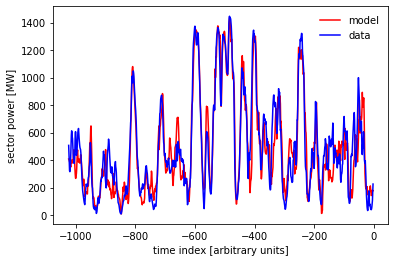

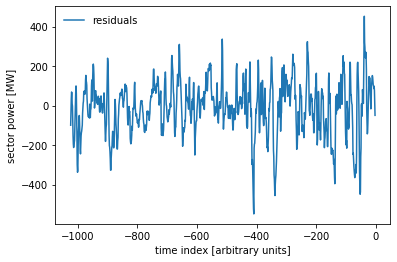

In [5]:
#for sector in [0, 1, 2, 3]:
    
# mean init
mean_init = torch.mean(sector_power[sector])/len(turbine_features[sector])

# initialize a neural network model for the turbine power outputs
ModelMean = RegressionNetwork(n_turbine_features=n_turbine_features, 
                        n_weather_features=n_weather_features, 
                        n_units=[64, 64], 
                        activation=leaky_relu,
                        init=mean_init)

# training parameters
learning_rate = 1e-2
epochs = 20
adam_regularisation = 0.0

# optimizer
optimiserMean = torch.optim.Adam(ModelMean.parameters(), lr=learning_rate, weight_decay=adam_regularisation)

# Mean training loop

# progress bar
pbar = tqdm.tqdm_notebook(total=epochs, desc = "Training")
pbar.set_postfix(ordered_dict={"loss":0}, refresh=True)

# holder for training loss
training_loss = []

# loop over epochs
for epoch in range(epochs):

    # construct batches
    batches = np.random.permutation(np.arange(10000)).reshape(10, 1000)

    # loop over time batches
    for t in range(len(batches)):

        # batch of time indicies
        batch = batches[t]

        # loop over sectors
        for s in [sector]:

                # calculate the predicted means and variances for those turbines in that sector, at that time
                # note: turbine features is n_turbines x n_features, and weather is n_times x n_turbines x n_features
                means = ModelMean(turbine_features[s], weather[s][batch,:,:])

                # calculate the predicted mean and variance for the whole sector
                # note that we multiply by "installed", which will kill any terms coming from turbines that were not installed at this time
                # installed is n_times x n_turbines
                sector_mean = torch.sum(means * installed[s][batch,:,:], axis=1)

                # calculate log_likelihoods
                neg_log_likelihood = torch.sqrt(torch.mean((sector_power[s][batch,:] - sector_mean).pow(2)))

                # add to the loss: this is the negative log-likelihood of a gaussian with the predicted sector mean and variance from above
                loss = neg_log_likelihood

        # backpropagation step (ie., gradient descent step)
        optimiserMean.zero_grad()
        loss.backward()
        optimiserMean.step()
        pbar.set_postfix(ordered_dict={"loss":loss.data.clone().numpy().flatten()[0]}, refresh=True)

    # save training loss
    training_loss.append(loss.data.clone().numpy().flatten()[0])

    # update progress bar
    pbar.update(1)
    pbar.set_postfix(ordered_dict={"loss":training_loss[-1]}, refresh=True)

# make predictions for this sector for some range of times
t0 = -1024
t1 = -1
mean = ModelMean(turbine_features[sector], weather[sector][t0:t1,:,:])
sector_mean = torch.sum(mean * installed[sector][t0:t1,:,:], axis=1).detach().numpy()[:,0]

# plot the predictions against the observations (mean only)
plt.plot(np.arange(t0, t1), sector_mean, color = 'red', label='model')
plt.plot(np.arange(t0, t1), sector_power[sector][t0:t1], color = 'blue', label='data')
plt.xlabel('time index [arbitrary units]')
plt.ylabel('sector power [MW]')
plt.legend(frameon=False)
plt.show()

# plot the residuals
plt.plot(np.arange(t0, t1), sector_mean-sector_power[sector][t0:t1].detach().numpy()[:,0], label='residuals')
plt.xlabel('time index [arbitrary units]')
plt.ylabel('sector power [MW]')
plt.legend(frameon=False)
plt.show()



In [ ]:
# calculate the current log variance to initialize
mean = ModelMean(turbine_features[sector], weather[sector])
sector_mean = torch.sum(mean * installed[sector], axis=1)
logvar_init = torch.log( torch.var(sector_power[sector] - sector_mean)/len(turbine_features[sector]) )

# initialize a neural network model for the variance of the turbine power outputs
ModelLogvar = RegressionNetwork(n_turbine_features=n_turbine_features, 
                        n_weather_features=n_weather_features, 
                        n_units=[64, 64], 
                        activation=leaky_relu,
                        init=logvar_init)

# training parameters
learning_rate = 1e-2
epochs = 20
adam_regularisation = 0.0

# optimizer
optimiserLogvar = torch.optim.Adam(ModelLogvar.parameters(), lr=learning_rate, weight_decay=adam_regularisation)

# Variance training loop

# progress bar
pbar = tqdm.tqdm_notebook(total=epochs, desc = "Training")
pbar.set_postfix(ordered_dict={"loss":0}, refresh=True)

# holder for training loss
training_loss = []

# loop over epochs
for epoch in range(epochs):

    # construct batches
    batches = np.random.permutation(np.arange(10000)).reshape(10, 1000)

    # loop over time batches
    for t in range(len(batches)):

        batch = batches[t]

        # loop over sectors
        for s in [sector]:

                # calculate the predicted means and variances for those turbines in that sector, at that time
                # note: turbine features is n_turbines x n_features, and weather is n_times x n_turbines x n_features
                means = ModelMean(turbine_features[s], weather[s][batch,:,:])
                log_variances = ModelLogvar(turbine_features[s], weather[s][batch,:,:])

                # calculate the predicted mean and variance for the whole sector
                # note that we multiply by "installed", which will kill any terms coming from turbines that were not installed at this time
                # installed is n_times x n_turbines
                sector_mean = torch.sum(means * installed[s][batch,:,:], axis=1)
                sector_variance = torch.sum(torch.exp(log_variances) * installed[s][batch,:,:], axis=1)

                # calculate log_likelihoods
                neg_log_likelihood = 0.5*(sector_power[s][batch,:] - sector_mean).pow(2)/sector_variance + 0.5*torch.log(sector_variance)

                # add to the loss: this is the negative log-likelihood of a gaussian with the predicted sector mean and variance from above
                loss = torch.sum(neg_log_likelihood)

        # backpropagation step (ie., gradient descent step)
        optimiserLogvar.zero_grad()
        loss.backward()
        optimiserLogvar.step()
        pbar.set_postfix(ordered_dict={"loss":loss.data.clone().numpy().flatten()[0]}, refresh=True)

    # save training loss
    training_loss.append(loss.data.clone().numpy().flatten()[0])

    # update progress bar
    pbar.update(1)
    pbar.set_postfix(ordered_dict={"loss":training_loss[-1]}, refresh=True)

# make predictions for this sector for some range of times (with uncertainties this time):

# choose some range of time indicies and make predictions (for power output mean and logvariance for each turbine)
t0 = -1024
t1 = -1
mean = ModelMean(turbine_features[sector], weather[sector][t0:t1,:,:])
logvar = ModelLogvar(turbine_features[sector], weather[sector][t0:t1,:,:])

# corresponding predictions for whole sector (mean and std dev)
sector_mean = torch.sum(mean * installed[sector][t0:t1,:,:], axis=1).detach().numpy()[:,0]
sector_std = torch.sqrt(torch.sum(torch.exp(logvar) * installed[sector][t0:t1,:,:], axis=1)).detach().numpy()[:,0]

# plot the predictions against the observations
plt.fill_between(np.arange(t0, t1), sector_mean - sector_std, sector_mean + sector_std, alpha=0.3, color = 'red', label=r'model$\pm \sigma$')
plt.plot(np.arange(t0, t1), sector_mean, color = 'red', label='model')
plt.plot(np.arange(t0, t1), sector_power[sector][t0:t1], color = 'blue', label='data')
plt.xlabel('time index [arbitrary units]')
plt.ylabel('sector power [MW]')
plt.legend(frameon=False)
plt.show()

# plot the residuals
plt.plot(np.arange(t0, t1), sector_mean-sector_power[sector][t0:t1].detach().numpy()[:,0], label='residuals')
plt.xlabel('time index [arbitrary units]')
plt.ylabel('sector power [MW]')
plt.legend(frameon=False)
plt.show()

In [ ]:
# Make predictions for the new round of data

# turbine features
turbines_SE1_v = torch.tensor(np.load('round2_data_prepared/turbines_SE1.npy'))
turbines_SE2_v = torch.tensor(np.load('round2_data_prepared/turbines_SE2.npy'))
turbines_SE3_v = torch.tensor(np.load('round2_data_prepared/turbines_SE3.npy'))
turbines_SE4_v = torch.tensor(np.load('round2_data_prepared/turbines_SE4.npy'))
turbine_features_shift = torch.tensor(np.load('data_prepared/turbine_features_shift.npy'))
turbine_features_scale = torch.tensor(np.load('data_prepared/turbine_features_scale.npy'))
turbine_features_v = [(turbines_SE1_v - turbine_features_shift)/turbine_features_scale, 
                        (turbines_SE2_v - turbine_features_shift)/turbine_features_scale, 
                        (turbines_SE3_v - turbine_features_shift)/turbine_features_scale, 
                        (turbines_SE4_v - turbine_features_shift)/turbine_features_scale]

# weather
weather_SE1_v = torch.tensor(np.load('round2_data_prepared/weather_at_turbine_locations_SE1.npy'))
weather_SE2_v = torch.tensor(np.load('round2_data_prepared/weather_at_turbine_locations_SE2.npy'))
weather_SE3_v = torch.tensor(np.load('round2_data_prepared/weather_at_turbine_locations_SE3.npy'))
weather_SE4_v = torch.tensor(np.load('round2_data_prepared/weather_at_turbine_locations_SE4.npy'))
weather_features_shift = torch.tensor(np.load('data_prepared/weather_features_shift.npy'))
weather_features_scale = torch.tensor(np.load('data_prepared/weather_features_scale.npy'))
weather_v = [(weather_SE1_v - weather_features_shift)/weather_features_scale, 
               (weather_SE2_v - weather_features_shift)/weather_features_scale, 
               (weather_SE3_v - weather_features_shift)/weather_features_scale, 
               (weather_SE4_v - weather_features_shift)/weather_features_scale]

# installed or not?
installed_SE1_v = torch.tensor(np.load('round2_data_prepared/installed_SE1.npy'))
installed_SE2_v = torch.tensor(np.load('round2_data_prepared/installed_SE2.npy'))
installed_SE3_v = torch.tensor(np.load('round2_data_prepared/installed_SE3.npy'))
installed_SE4_v = torch.tensor(np.load('round2_data_prepared/installed_SE4.npy'))
installed_v = [installed_SE1_v, installed_SE2_v, installed_SE3_v, installed_SE4_v]

# sector energy
sector_power_SE1_v = torch.tensor(np.load('round2_data_prepared/sector_power_SE1.npy'))
sector_power_SE2_v = torch.tensor(np.load('round2_data_prepared/sector_power_SE2.npy'))
sector_power_SE3_v = torch.tensor(np.load('round2_data_prepared/sector_power_SE3.npy'))
sector_power_SE4_v = torch.tensor(np.load('round2_data_prepared/sector_power_SE4.npy'))
sector_power_v = [sector_power_SE1_v, sector_power_SE2_v, sector_power_SE3_v, sector_power_SE4_v]

In [ ]:
# construct percentiles and save
means = ModelMean(turbine_features_v[sector], weather_v[sector])
logvar = ModelLogvar(turbine_features_v[sector], weather_v[sector])
sector_mean = torch.sum(means * installed_v[sector], axis=1).detach().numpy()[:,0]
sector_std = torch.sqrt(torch.sum(torch.exp(logvar) * installed_v[sector], axis=1)).detach().numpy()[:,0]
maximum = np.max(sector_power[sector].detach().numpy())
minimum = np.min(sector_power[sector].detach().numpy())

percentiles = np.zeros((len(weather_v[sector]), 9))

for i in range(len(weather_v[sector])):

    samples = np.random.normal(sector_mean[i], sector_std[i], 10000)
    samples[(samples > minimum) * (samples < maximum)]
    percentiles[i,:] = np.percentile(samples, [10, 20, 30, 40, 50, 60, 70, 80, 90])

np.save('round2_percentiles/percentiles_SE{}.npy'.format(sector+1), percentiles)